# Launch Experiments with wandb.init

在脚本开头调用一次 `wandb.init()` 来初始化新作业。这会在 W&B 中创建一个新的运行，并启动一个后台进程来同步数据。

- **On-Prem**: 如果您需要 W&B 的私有云或本地实例，请参阅我们的自助服务。
- **Automated Environments**: 这些设置中的大多数也可以通过环境变量进行控制。当您在集群上运行作业时，这通常非常有用。


## Common Questions

### How do I launch multiple runs from one script?

如果您试图从一个脚本启动多个运行，请在代码中添加两件事：

- `run = wandb.init(reinit=True)`: 使用此设置允许重新初始化运行
- `run.finish()`: 在运行结束时使用此功能来完成该运行的日志记录

In [ ]:
import wandb

for x in range(10):
    run = wandb.init(reinit=True)
    for y in range(100):
        wandb.log({"metric": x+y})
    run.finish()

或者，您可以使用 python 上下文管理器来自动完成日志记录：

In [ ]:
import wandb

for x in range(10):
    run = wandb.init(reinit=True)
    with run:
        for y in range(100):
            run.log({"metric": x+y})

### InitStartError: Error communicating with wandb process

此错误表明库在启动将数据同步到服务器的进程时遇到困难。

在某些环境中，以下临时应对办法可以帮助解决问题：

In [ ]:
wandb.init(settings=wandb.Settings(start_method="fork"))

### How can I use wandb with multiprocessing, e.g. distributed training?

如果您的训练程序使用多个进程，则需要构建程序，以避免从没有运行 `wandb.init()` 的进程进行 `wandb` 方法调用。

管理多进程训练有几种方法：

- 在您的所有进程中调用 `wandb.init`，使用 `group` 关键字参数定义共享组。每个进程都有自己的 `wandb` 运行，UI将把训练过程分组在一起。
- 仅从一个进程调用 `wandb.init`，并将数据传递到  multiprocessing queues 中记录。

### How do I programmatically access the human-readable run name?

它作为 `wandb.Run` 的 `.name` 属性可用。

In [1]:
import wandb

wandb.init()
run_name = wandb.run.name

wandb: Currently logged in as: shawndong98. Use `wandb login --relogin` to force relogin


### Can I just set the run name to the run ID?

如果您想用运行ID（如qvlp96vk）覆盖运行名称（如snowy-owl-10），您可以使用以下片段：

In [2]:
import wandb
wandb.init()
wandb.run.name = wandb.run.id
wandb.run.save()

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

### I didn't name my run. Where is the run name coming from?

如果您没有显式命名您的运行，则将向运行分配一个随机运行名称，以帮助识别UI中的 runs。例如，随机运行名称将看起来像 “pleasant-flower-4” 或 “misunderunderunderod-glade-2”。

### How can I save the git commit associated with my run?

当您的脚本中调用 `wandb.init` 时，我们会自动查找要保存的git信息，包括指向 remote repo 和最新提交SHA的链接。Git信息应该显示在您的运行页面上。如果您没有看到它出现在那里，请确保在执行脚本时shell的当前工作目录位于git管理的文件夹中。

用于运行实验的git commit和命令对您可见，但对外部用户是隐藏的，因此如果您有一个公共项目，这些详细信息将保持私密性。

### Is it possible to save metrics offline and sync them to W&B later?

默认情况下，wandb.init 启动一个流程，将指标实时同步到我们的云托管应用程序。如果您的机器处于离线状态，您无法访问互联网，或者您只是想推迟上传，以下是如何在离线模式下运行 `wandb` 并稍后同步。

您需要设置两个环境变量:

- `WANDB_API_KEY=$KEY`, 其中 `$KEY` 是你设置页面的 API key。
- `WANDB_MODE="offline"`

以下是您在脚本中会是什么样子的示例：

In [5]:
import wandb
import os

os.environ["WANDB_API_KEY"] = "073470cde6787ca1d19241f9d1956b365f9f19b6"
os.environ["WANDB_MODE"] = "offline"

config = {
    "dataset": "CIFAR10",
    "machine": "offline cluster",
    "model": "CNN",
    "learning_rate": 0.01,
    "batch_size": 128,
}

wandb.init(project="offline-demo")

for i in range(100):
    wandb.log({"accuracy": i})

wandb: Network error (ReadTimeout), entering retry loop.


以下是终端输出示例：

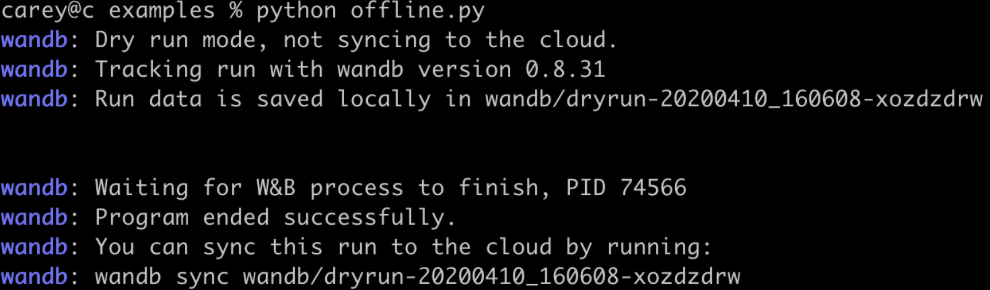

一旦您准备好了，只需运行一个同步命令即可将该文件夹发送到云端。

In [6]:
!wandb sync wandb/dryrun-folder-name

Usage: wandb sync [OPTIONS] [PATH]...
Try 'wandb sync --help' for help.

Error: Invalid value for '[PATH]...': Path 'wandb/dryrun-folder-name' does not exist.


### My run's state is "crashed" on the UI but is still running on my machine. What do I do to get my data back?
 
您很可能在训练期间失去了与机器的连接。您可以通过运行 wandb 同步 `[PATH_TO_RUN]` 恢复数据。运行路径将是 wandb 目录中与正在进行的运行的运行 ID 相对应的文件夹。

### `LaunchError: Permission denied`

如果您收到错误消息启动错误：权限被拒绝，则您没有权限登录您试图发送运行的项目。这可能有几个不同的原因。

- 您没有登录这台机器。在命令行上运行 `wandb login`。
- 您设置了一个不存在的 entity。“Entity” 应该是您的用户名或现有团队的名称。如果您需要创建团队，请转到我们的订阅页面。
- 您没有项目权限。让项目的创建者将隐私设置为打开，以便您可以记录该项目的运行情况。

### Does W&B uses the multiprocessing library?

是的，W&B使用 `multiprocessing` 库。如果您看到错误信息，例如：


```
An attempt has been made to start a new process before the current process 
has finished its bootstrapping phase.
```

这可能意味着，如果 `name == main`，您可能需要添加入口点保护。请注意，如果您试图直接从脚本运行 W&B，您只需要添加此入口点保护。